In [1]:
import numpy as np, pandas as pd

In [5]:
tracks = pd.read_csv('../datasets/Classify Song Genres from Audio Data/rock-vs-hiphop.csv')
music_features = pd.read_json('../datasets/Classify Song Genres from Audio Data/echonest-metric.json',precise_float=True)

In [7]:
tracks.isnull().sum()

track_id             0
bit_rate             0
comments             0
composer         17568
date_created         0
date_recorded    15836
duration             0
favorites            0
genre_top            0
genres               0
genres_all           0
information      17252
interest             0
language_code    13645
license             20
listens              0
lyricist         17681
number               0
publisher        17682
tags                 0
title                0
dtype: int64

In [8]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score

In [9]:
audio_data=music_features.merge(tracks[['genre_top', 'track_id']], on='track_id')

In [10]:
audio_data.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


In [11]:
audio_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 375.3+ KB


In [12]:
audio_data.isnull().sum()

track_id            0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
speechiness         0
tempo               0
valence             0
genre_top           0
dtype: int64

### Feature Reduction¶
This is important as with many features, we run the risk of overfitting our model. At the same time, a reducded number of features will decrease the computation time of the model making it predict results much quicker.

First lets look at correlations and then try Principal Component Analysis (PCA).

#### 1. Checking relationships between variables/features
This is done to check for variables that have strong correlations with each other, this will help to avoid feature redundancy

<Axes: >

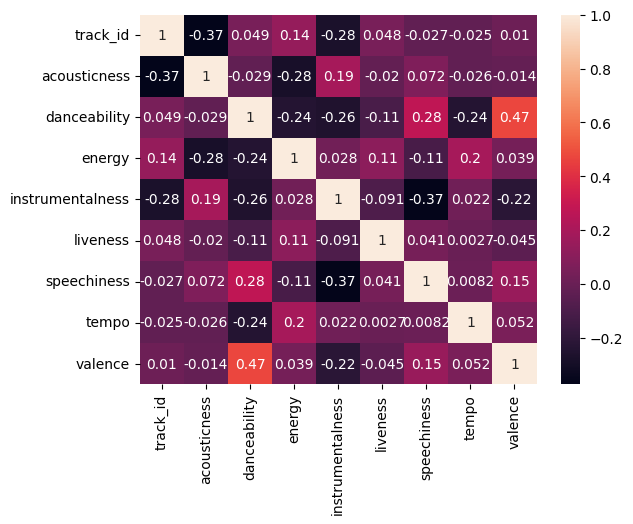

In [19]:
correlations = audio_data.select_dtypes(exclude='object').corr()
import seaborn as snss
sns.heatmap(correlations, annot=True)

In [20]:
features = audio_data.drop(['genre_top','track_id'], axis=1)
labels = audio_data['genre_top']

In [21]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [22]:
pca = PCA()
pca.fit_transform(scaled_features)
explained_variance = pca.explained_variance_ratio_
num_com = pca.n_components_

Text(0.5, 0, 'Principal Component #')

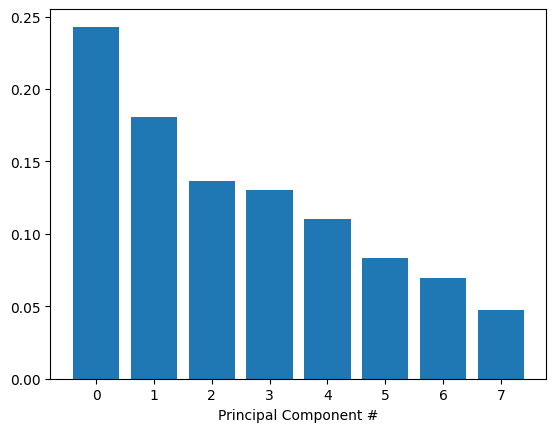

In [24]:
fig, ax = plt.subplots()
ax.bar(range(num_com), explained_variance)
ax.set_xlabel('Principal Component #')

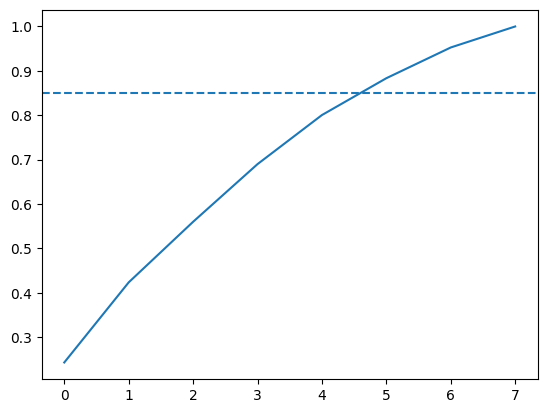

In [25]:
cum_exp_variance = np.cumsum(explained_variance) #calculate the cumulative explained variance

fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

In [26]:
# From the figure, I can say about 6 features are needed to explain 85% of the variance, hence this is the number of features I will use to carry out the model training with.
pca = PCA(6, random_state=10)
pca.fit(scaled_features)
pca_projection = pca.transform(scaled_features)

In [27]:
pca_projection.shape

(4802, 6)

In [28]:
pca_projection

array([[ 1.59666656,  1.0500117 , -0.01778555,  0.73142514, -0.36832686,
        -0.71505324],
       [ 1.58153526,  1.07661327,  1.04346038,  0.16929959, -1.81917099,
         1.3884574 ],
       [ 2.01545627,  1.4085176 ,  0.24506524, -1.53545814,  0.62769959,
        -0.45716338],
       ...,
       [ 1.66908628,  1.84010121,  2.38294303, -2.12871589,  1.23664547,
        -0.63277253],
       [ 1.17001951,  2.03158181,  0.08689922,  0.88396123, -1.45765649,
        -0.03590123],
       [ 2.36368976,  1.15900708,  0.4473735 , -1.35198128, -0.03592518,
         0.82678557]])

## Model Training

In [29]:
X_train, X_test, y_train, y_test = train_test_split(pca_projection, labels, random_state=10)
labels

0       Hip-Hop
1       Hip-Hop
2       Hip-Hop
3       Hip-Hop
4          Rock
         ...   
4797    Hip-Hop
4798    Hip-Hop
4799    Hip-Hop
4800    Hip-Hop
4801    Hip-Hop
Name: genre_top, Length: 4802, dtype: object

In [30]:
model_dt = DecisionTreeClassifier(random_state=10)
model_dt.fit(X_train,y_train)

DecisionTreeClassifier(random_state=10)

In [31]:
predictions_dt = model_dt.predict(X_test)
print("Decision Tree Classifier:", model_dt.score(X_test,y_test))

Decision Tree Classifier: 0.8434637801831807


In [32]:
model_lg = LogisticRegression(random_state=10)
model_lg.fit(X_train,y_train)

LogisticRegression(random_state=10)

In [33]:
predictions_lg = model_lg.predict(X_test)
print("Logistic Regression:", model_lg.score(X_test,y_test))

Logistic Regression: 0.8784346378018318


In [34]:
report_dt = classification_report(y_test,predictions_dt)
report_lg = classification_report(y_test,predictions_lg)

print("Decision Tree Classifier: \n", report_dt)
print("Logistic Regression: \n", report_lg)

Decision Tree Classifier: 
               precision    recall  f1-score   support

     Hip-Hop       0.60      0.60      0.60       235
        Rock       0.90      0.90      0.90       966

    accuracy                           0.84      1201
   macro avg       0.75      0.75      0.75      1201
weighted avg       0.84      0.84      0.84      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



<Axes: xlabel='count', ylabel='genre_top'>

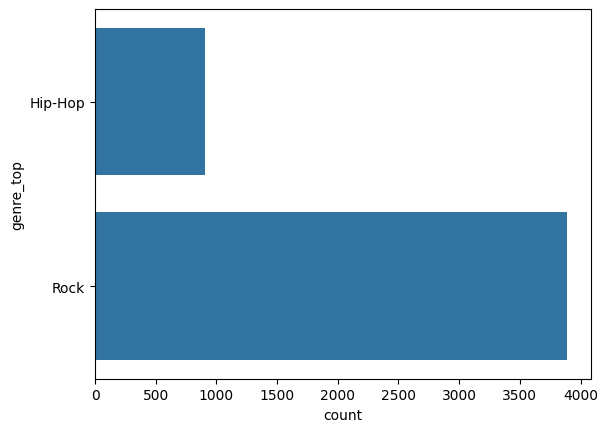

In [35]:
sns.countplot(audio_data['genre_top'], label = "Count")

In [36]:
hip_hop = audio_data.loc[audio_data['genre_top'] == 'Hip-Hop']
rock = audio_data.loc[audio_data['genre_top'] == 'Rock']

In [37]:
hip_hop.shape

(910, 10)

In [38]:
rock.shape

(3892, 10)

3892 rock songs compared to only 910 hip hop songs. Remove this imbalance by sampling the rock songs to have the same number as hip hop

In [39]:
rock = rock.sample(hip_hop.shape[0], random_state=10)

In [40]:
balanced_data = pd.concat([rock, hip_hop])
balanced_data.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
773,4038,0.825838,0.263645,0.797948,0.842318,0.177089,0.045277,166.580,0.713586,Rock
2273,19501,0.966635,0.386114,0.651980,0.869472,0.353138,0.032208,130.767,0.712374,Rock
2846,31252,0.721510,0.358035,0.948187,0.801184,0.105706,0.095522,125.884,0.208728,Rock
2147,17947,0.617370,0.487321,0.918848,0.817050,0.089908,0.040337,129.565,0.268893,Rock
2654,27421,0.025464,0.245523,0.422381,0.938011,0.441009,0.038795,149.960,0.439876,Rock


In [41]:
balanced_data['genre_top'].value_counts()

genre_top
Rock       910
Hip-Hop    910
Name: count, dtype: int64

In [42]:
features = balanced_data.drop(['genre_top', 'track_id'], axis=1) 
labels = balanced_data['genre_top']

In [43]:
pca_projection = pca.fit_transform(scaler.fit_transform(features))
pca_projection.shape

(1820, 6)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(pca_projection, labels, random_state=10)

In [45]:
#train decision tree on the balanced data
model_dt = DecisionTreeClassifier(random_state=10).fit(X_train, y_train)
predictions_dt = model_dt.predict(X_test)

In [46]:
model_lg = LogisticRegression(random_state=10).fit(X_train, y_train)
predictions_lg = model_lg.predict(X_test)

In [48]:
# compare the models
print("Decision Tree: \n", classification_report(y_test, predictions_dt))
print("Logistic Regression: \n", classification_report(y_test, predictions_lg))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.74      0.73      0.74       230
        Rock       0.73      0.74      0.73       225

    accuracy                           0.74       455
   macro avg       0.74      0.74      0.74       455
weighted avg       0.74      0.74      0.74       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.80      0.82       230
        Rock       0.80      0.85      0.83       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.82      0.82      0.82       455

